## References:

https://www.tensorflow.org/recommenders/examples/dcn

https://arxiv.org/pdf/2008.13535.pdf

This notebook focuses on building recommendation systems using collaborative filtering and deep learning techniques.

First, I preprocess transactional data, scale and transform these interactions to prepare them for modeling.

Then, I create TensorFlow datasets and define models for collaborative filtering and a Deep & Cross Network (DCN). These models are trained and evaluated using different configurations to find the best-performing one.

During training, I monitor metrics like Root Mean Squared Error (RMSE) on validation sets and choose models with the lowest RMSE. I compare different models' performance based on their mean RMSE and standard deviation across various interaction volumes.

Additionally, I analyze the training process by plotting validation RMSE against training size, fitting a polynomial regression curve to understand the trend.

Finally, I select the best model and evaluate its performance on the test set to make recommendations. The entire process involves extensive data preprocessing, model training, evaluation, and performance analysis to build an effective recommendation system.

Keys steps involved:

- The code imports necessary libraries and sets up the environment.
- It reads transaction data, preprocesses it, aggregates interactions, scales features, and creates timestamp buckets before converting into TensorFlow Datasets for model training.
- Main models defined: Collaborative Filtering Model and Deep & Cross Network (DCN) Model (including it's variants and DNN as a special case).
- The code trains multiple instances of all models with different configurations.
- It evaluates their performance using RMSE (Root Mean Squared Error) as the metric.
- It selects the best-performing model based on the evaluation results.
- The code visualizes the RMSE of different models across various interaction volumes.
- The best-performing model is selected and trained on the full dataset.
- It evaluates the model's performance on a test set and displays the predictions.
- It plots the RMSE versus the number of interactions and analyzes the performance.
- A polynomial regression curve is fitted to the validation RMSE to analyze the trend over different training sizes.

## Preparing environment and initializing TensorFlow

In [1]:
# Importing necessary libraries
import os
import gc
import time
import datetime
import pprint
import shutil
import tempfile
from typing import Dict, Text

# Importing data manipulation & plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Setting environment variable for TensorFlow
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Importing TensorFlow and TensorFlow libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from tensorflow.keras.callbacks import EarlyStopping

# Setting random seed for reproducibility
tf.random.set_seed(42)

# Set Seaborn style
sns.set(style="whitegrid")

## Preparing data

In [2]:
# Reading transaction data
df = pd.read_csv(
    '../data/all_transaction_data.csv'
).sample(1000000)

# Transforming 'quantity' and 'price' columns into 'cost' by scaling between 0 and 1
df['cost'] = (df['quantity'] * df['price']).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Aggregating interactions by grouping user, product, timestamp, city, and category, and computing sum of 'cost' and mean of 'review_score'
interactions_df = df.groupby(['user_id', 'product_id', 'timestamp', 'customer_city', 'product_category']).agg({'cost': 'sum', 'review_score': 'mean'}).reset_index().rename(columns={'review_score': 'rating'})

# Scaling 'rating' between 0 and 1
interactions_df['rating'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

# Creating timestamp buckets of 24 hours
timestamp_buckets = np.arange(interactions_df['timestamp'].min(), interactions_df['timestamp'].max() + 24 * 60 * 60, 24 * 60 * 60)
interactions_df['timestamp_buckets'] = pd.cut(interactions_df['timestamp'], bins=timestamp_buckets, labels=False)

# Handling zero values in 'cost' and 'rating' by replacing them with 0.1
interactions_df['cost'] = interactions_df['cost'].replace(0, 0.1)
interactions_df['rating'] = interactions_df['rating'].replace(0, 0.1)

# Computing 'score' by multiplying 'cost' and 'rating'
interactions_df['score'] = interactions_df['cost'] * interactions_df['rating']

# Creating score percentiles and mapping scores to corresponding labels
percentiles = [0, 20, 40, 60, 80, 100]
thresholds = [interactions_df['score'].quantile(p / 100) for p in percentiles]
labels = [str(i) for i in range(1, len(percentiles))]
interactions_df['score'] = pd.cut(interactions_df['score'], bins=thresholds, labels=labels, include_lowest=True).astype(int)

# Converting DataFrame to dictionary for TensorFlow Dataset creation
interactions_dict = {name: np.array(value) for name, value in interactions_df.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

# Mapping features to appropriate data types and printing sample interaction
interactions = interactions.map(lambda x: {
    "product_id": x["product_id"],
    "user_id": x["user_id"],
    "timestamp_buckets": int(x["timestamp_buckets"]),
    "customer_city": x["customer_city"],
    "product_category": x["product_category"],
    "score": float(x["score"])
})
print("\nInteraction sample:")
for x in interactions.take(1).as_numpy_iterator():
    pprint.pprint(x)

# Total number of interactions
print(f"\nTotal interactions: {len(interactions)}")


Interaction sample:
{'customer_city': b'cajamar',
 'product_category': b'UNKNOWN',
 'product_id': b'UNKNOWN SKU 4',
 'score': 2.0,
 'timestamp_buckets': 164,
 'user_id': b'0000366f3b9a7992bf8c76cfdf3221e2'}

Total interactions: 1000000


## Generating vocabularies

In [3]:
# Defining feature names for which vocabularies will be created
feature_names = [
    'customer_city',
    'product_category',
    'product_id',
    'timestamp_buckets',
    'user_id'
]

# Dictionary to store vocabularies for each feature
vocabularies = {}

for feature_name in feature_names:
    print(f"\nCreating vocabulary for {feature_name}")
    
    # Extracting unique values for the current feature
    vocab = interactions.batch(len(interactions)).map(lambda x: x[feature_name])
    vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))
    print("Finished!")


Creating vocabulary for customer_city
Finished!

Creating vocabulary for product_category
Finished!

Creating vocabulary for product_id
Finished!

Creating vocabulary for timestamp_buckets
Finished!

Creating vocabulary for user_id
Finished!


## Collaborative Filtering Model for Recommendation Systems

In [4]:
class CollaborativeFilteringModel(tfrs.Model):
    """
    Collaborative filtering model for recommendation systems.

    Args:
        embedding_dimension (int, optional): The dimensionality of the embedding vectors.
            If not provided, it will be calculated automatically based on the vocabulary size.
    """

    def __init__(self, embedding_dimension=None):
        """
        Initializes the CollaborativeFilteringModel.

        Args:
            embedding_dimension (int, optional): The dimensionality of the embedding vectors.
                If not provided, it will be calculated automatically based on the vocabulary size.
        """
        super().__init__()
        
        # User embeddings
        user_vocab = vocabularies['user_id']
        if embedding_dimension is None:
            embedding_dimension = int((len(user_vocab) + 1) ** 0.25) + 1
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=user_vocab, mask_token=None),
            tf.keras.layers.Embedding(len(user_vocab) + 1, embedding_dimension)
        ])
        
        # Item embeddings
        item_vocab = vocabularies['product_id']
        if embedding_dimension is None:
            embedding_dimension = int((len(item_vocab) + 1) ** 0.25) + 1
        self.item_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(
                vocabulary=item_vocab, mask_token=None),
            tf.keras.layers.Embedding(len(item_vocab) + 1, embedding_dimension)
        ])
        
        # Ranking task
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )

    def call(self, features):
        """
        Computes the forward pass of the model.

        Args:
            features (dict): A dictionary containing input features, including "user_id" and "product_id".

        Returns:
            tf.Tensor: The predicted scores for user-item pairs.
        """
        user_embeddings = self.user_embedding(features["user_id"])
        item_embeddings = self.item_embedding(features["product_id"])
        
        return tf.reduce_sum(user_embeddings * item_embeddings, axis=1)

    def compute_loss(self, features, training=False):
        """
        Computes the loss for training the model.

        Args:
            features (dict): A dictionary containing input features, including "user_id", "product_id", and "score".
            training (bool, optional): Whether the model is in training mode. Defaults to False.

        Returns:
            tf.Tensor: The computed loss value.
        """
        labels = features.pop("score")
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )

## Deep & Cross Network (DCN) for Recommendation Systems

In [5]:
class DCN(tfrs.Model):
    """
    Deep & Cross Network (DCN) model for recommendation systems.

    Args:
        cross_layer_num (int): Number of cross layers in the DCN.
        deep_layer_sizes (list of int): Sizes of the deep layers in the DCN.
        projection_dim (int, optional): Dimensionality of the projection in the cross layers.
        embedding_dimension (int, optional): Dimensionality of the embedding vectors.
            If not provided, it will be calculated automatically based on the vocabulary size.
    """

    def __init__(self, cross_layer_num, deep_layer_sizes, projection_dim=None, embedding_dimension=None):
        """
        Initializes the DCN model.

        Args:
            cross_layer_num (int): Number of cross layers in the DCN.
            deep_layer_sizes (list of int): Sizes of the deep layers in the DCN.
            projection_dim (int, optional): Dimensionality of the projection in the cross layers.
            embedding_dimension (int, optional): Dimensionality of the embedding vectors.
                If not provided, it will be calculated automatically based on the vocabulary size.
        """
        super().__init__()
        
        # Define features
        str_features = [
            'customer_city',
            'product_category',
            'product_id',
            'user_id'
        ]
        int_features = ['timestamp_buckets']

        self._all_features = str_features + int_features
        self._embeddings = {}
        
        # Initialize embeddings for string features
        for feature_name in str_features:
            vocabulary = vocabularies[feature_name]
            if embedding_dimension is None:
                embedding_dimension = int((len(vocabulary) + 1) ** 0.25) + 1
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.StringLookup(
                    vocabulary=vocabulary, mask_token=None),
                tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            embedding_dimension)
            ])
        
        # Initialize embeddings for integer features
        for feature_name in int_features:
            vocabulary = vocabularies[feature_name]
            if embedding_dimension is None:
                embedding_dimension = int((len(vocabulary) + 1) ** 0.25) + 1
            self._embeddings[feature_name] = tf.keras.Sequential(
                [tf.keras.layers.IntegerLookup(
                    vocabulary=vocabulary, mask_token=None),
                tf.keras.layers.Embedding(len(vocabulary) + 1,
                                            embedding_dimension)
            ])
        
        # Cross layers
        self._cross_layers = [tfrs.layers.dcn.Cross(
            projection_dim=projection_dim,
            kernel_initializer="glorot_uniform"
        ) for i in range(cross_layer_num)]
        
        # Deep layers
        self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layer_sizes]
        
        # Logit layer
        self._logit_layer = tf.keras.layers.Dense(1)
        
        # Ranking task
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
        )

    def call(self, features):
        """
        Computes the forward pass of the DCN model.

        Args:
            features (dict): A dictionary containing input features.

        Returns:
            tf.Tensor: The predicted scores for the given features.
        """
        embeddings = []
        for feature_name in self._all_features:
            embedding_fn = self._embeddings[feature_name]
            embeddings.append(embedding_fn(features[feature_name]))

        x0 = tf.concat(embeddings, axis=1)
        x = tf.concat(embeddings, axis=1)
        
        # Cross layers
        for cross_layer in self._cross_layers:
            x = cross_layer(x0, x)
        
        # Deep layers
        for deep_layer in self._deep_layers:
            x = deep_layer(x)

        return self._logit_layer(x)

    def compute_loss(self, features, training=False):
        """
        Computes the loss for training the DCN model.

        Args:
            features (dict): A dictionary containing input features.
            training (bool, optional): Whether the model is in training mode. Defaults to False.

        Returns:
            tf.Tensor: The computed loss value.
        """
        labels = features.pop("score")
        scores = self(features)
        return self.task(
            labels=labels,
            predictions=scores,
        )

## Run Collaborative Filtering Models

In [6]:
def run_cf_models(num_runs=1, embedding_dimension=None):
    """
    Runs multiple instances of the Collaborative Filtering Model with different configurations
    and evaluates their performance.

    Args:
        num_runs (int, optional): Number of runs for the models. Defaults to 1.
        embedding_dimension (int, optional): Dimensionality of the embedding vectors. Defaults to None.

    Returns:
        dict: A dictionary containing the trained models, mean RMSE, and standard deviation of RMSE.
    """
    models = []
    rmses = []

    for i in range(num_runs):
        model = CollaborativeFilteringModel(embedding_dimension=32)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(train.batch(64).cache(), epochs=epochs, verbose=False)
        metrics = model.evaluate(val.batch(32), return_dict=True)
        rmses.append(metrics["RMSE"])
        
    mean, stdv = np.average(rmses), np.std(rmses)
    
    return {"model": models, "mean": mean, "stdv": stdv}

## Run Deep & Cross Network (DCN) Models

In [7]:
def run_models(cross_layer_num, deep_layer_sizes, projection_dim=None, num_runs=1, embedding_dimension=None):
    """
    Runs multiple instances of the Deep & Cross Network (DCN) model with different configurations
    and evaluates their performance.

    Args:
        cross_layer_num (int): Number of cross layers in the DCN.
        deep_layer_sizes (list of int): Sizes of the deep layers in the DCN.
        projection_dim (int, optional): Dimensionality of the projection in the cross layers. Defaults to None.
        num_runs (int, optional): Number of runs for the models. Defaults to 1.
        embedding_dimension (int, optional): Dimensionality of the embedding vectors. Defaults to None.

    Returns:
        dict: A dictionary containing the trained models, mean RMSE, and standard deviation of RMSE.
    """
    models = []
    rmses = []

    for i in range(num_runs):
        model = DCN(cross_layer_num=cross_layer_num,
                    deep_layer_sizes=deep_layer_sizes,
                    projection_dim=projection_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
        models.append(model)

        model.fit(train.batch(64).cache(), epochs=epochs, verbose=False)
        metrics = model.evaluate(val.batch(32).cache(), return_dict=True)
        rmses.append(metrics["RMSE"])

    mean, stdv = np.average(rmses), np.std(rmses)

    return {"model": models, "mean": mean, "stdv": stdv}

## Compare Models

In [8]:
def compare_models(models):
    """
    Compares the performance of multiple models based on their mean RMSE and standard deviation.

    Args:
        models (list of tuples): List of tuples containing model instances, mean RMSE, standard deviation, and additional information.

    Returns:
        tuple: A tuple containing the best model, its mean RMSE, and standard deviation.
    """
    best_model = None
    best_rmse_mean = float('inf')
    best_stdv = float('inf')
    
    for model, rmse_mean, stdv, _ in models:
        if rmse_mean < best_rmse_mean or (rmse_mean == best_rmse_mean and stdv < best_stdv):
            best_model = model
            best_rmse_mean = rmse_mean
            best_stdv = stdv
    
    return best_model, best_rmse_mean, best_stdv

## Model Training and Evaluation

This script trains and evaluates multiple recommendation models with varying configurations. It compares their performance based on mean RMSE and standard deviation across different volumes of interactions.

Comments:
- The script iterates over different volumes of interactions, dividing the data into training and testing sets.
- It trains several models including Collaborative Filtering, DCN, DCN (low-rank), DNN, DCN V2, and DCN V2 (low-rank).
- Each model is trained multiple times to account for randomness in initialization.
- The function `compare_models` selects the best-performing model based on mean RMSE and standard deviation.
- The results are collected and stored for further analysis.

In [9]:
# Define hyperparameters
epochs = 5
learning_rate = 0.001

n_interactions = len(interactions)
shuffled = interactions.shuffle(10_000, seed=42, reshuffle_each_iteration=False).take(n_interactions)

# Splitting into train, validation, and test sets
train_size = int(0.5 * n_interactions)
eval_size = int(0.25 * n_interactions)
all_train = shuffled.take(train_size)
val = shuffled.skip(train_size).take(eval_size)
test = shuffled.skip(train_size + eval_size)

print(f"\nTrain Size: {len(all_train)}, Validation Size: {len(val)}, Test Size: {len(test)}")

# Lists to store results and metrics
num_interactions = []
best_models = []
best_rmse_means = []
best_stdvs = []
all_results = []

# Start time for tracking total training time
train_start_time = time.time()

for i in range(10):
    loop_start_time = time.time()
    
    i_train_size = int(len(all_train)/10)*(i+1)
    train = all_train.take(i_train_size)
    n_interactions = len(train)
    
    print(f"\nRunning with {n_interactions} training samples")
    
    loop_start_time = time.time()
    
    models = []
    
    # Train Collaborative Filtering (baseline) model
    start_time = time.time()
    print("\nCollaborative filtering model training in progress...")
    cf_result = run_cf_models(embedding_dimension=16)
    models.append(("Collaborative Filtering (baseline)", cf_result["mean"], cf_result["stdv"], n_interactions))
    del cf_result
    gc.collect()
    print("Time taken for collaborative filtering model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Train DCN model
    start_time = time.time()
    print("\nDCN model training in progress...")
    dcn_result = run_models(cross_layer_num=1,
                            deep_layer_sizes=[64, 64],
                            embedding_dimension=16)
    models.append(("DCN", dcn_result["mean"], dcn_result["stdv"], n_interactions))
    del dcn_result
    gc.collect()
    print("Time taken for DCN model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Train DCN (low-rank) model
    start_time = time.time()
    print("\nDCN (low-rank) model training in progress...")
    dcn_lr_result = run_models(cross_layer_num=1,
                               projection_dim=16,
                               deep_layer_sizes=[64, 64],
                               embedding_dimension=16)
    models.append(("DCN (low-rank)", dcn_lr_result["mean"], dcn_lr_result["stdv"], n_interactions))
    del dcn_lr_result
    gc.collect()
    print("Time taken for DCN (low-rank) model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Train DNN model
    start_time = time.time()
    print("\nDNN model training in progress...")
    dnn_result = run_models(cross_layer_num=0,
                            deep_layer_sizes=[64, 64, 64],
                            embedding_dimension=16)
    models.append(("DNN", dnn_result["mean"], dnn_result["stdv"], n_interactions))
    del dnn_result
    gc.collect()
    print("Time taken for DNN model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Train DCN V2 model
    start_time = time.time()
    print("\nDCN V2 model training in progress...")
    dcn_v2_result = run_models(cross_layer_num=2,
                               deep_layer_sizes=[64, 64],
                               embedding_dimension=16)
    models.append(("DCN V2", dcn_v2_result["mean"], dcn_v2_result["stdv"], n_interactions))
    del dcn_v2_result
    gc.collect()
    print("Time taken for DCN V2 model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Train DCN V2 (low-rank) model
    start_time = time.time()
    print("\nDCN V2 (low-rank) model training in progress...")
    dcn_v2_lr_result = run_models(cross_layer_num=2,
                                  projection_dim=16,
                                  deep_layer_sizes=[64, 64],
                                  embedding_dimension=16)
    models.append(("DCN V2 (low-rank)", dcn_v2_lr_result["mean"], dcn_v2_lr_result["stdv"], n_interactions))
    del dcn_v2_lr_result
    gc.collect()
    print("Time taken for DCN V2 (low-rank) model training:", str(datetime.timedelta(seconds=(time.time() - start_time))))
    
    # Evaluate models and select the best one
    print("\nEvaluation Results:")
    all_results.append(models)
    best_model, best_rmse_mean, best_stdv = compare_models(models)
    num_interactions.append(n_interactions)
    best_models.append(best_model)
    best_rmse_means.append(best_rmse_mean)
    best_stdvs.append(best_stdv)
    
    # Print the best model and its metrics
    print("\nBest model: {}, RMSE mean: {:.4f}, stdv: {:.4f}".format(best_model, best_rmse_mean, best_stdv))
    
    # Clear memory and print time taken for the entire loop execution
    del models
    gc.collect()
    print("Time taken for entire loop execution:", str(datetime.timedelta(seconds=(time.time() - loop_start_time))))

# Flatten the results list and create DataFrames for further analysis
flattened_results = [item for sublist in all_results for item in sublist]
all_results_df = pd.DataFrame(flattened_results, columns=['Model', 'RMSE Mean', 'Stdv', 'Interactions'])

best_results_df = pd.DataFrame({
    'Interactions Volume': num_interactions,
    'Best Models': best_models,
    'Best RMSE Means': best_rmse_means,
    'Best Standard Deviations': best_stdvs
})

# Print total training time
print("Total training time:", str(datetime.timedelta(seconds=(time.time() - train_start_time))))


Train Size: 500000, Validation Size: 250000, Test Size: 250000

Running with 50000 training samples

Collaborative filtering model training in progress...
7813/7813 [==============================] - 18s 1ms/step - RMSE: 3.3084 - loss: 10.9453 - regularization_loss: 0.0000e+00 - total_loss: 10.9453
Time taken for collaborative filtering model training: 0:00:26.656713

DCN model training in progress...
7813/7813 [==============================] - 22s 1ms/step - RMSE: 1.6482 - loss: 2.7163 - regularization_loss: 0.0000e+00 - total_loss: 2.7163
Time taken for DCN model training: 0:00:41.698375

DCN (low-rank) model training in progress...
7813/7813 [==============================] - 20s 1ms/step - RMSE: 1.6999 - loss: 2.8895 - regularization_loss: 0.0000e+00 - total_loss: 2.8895
Time taken for DCN (low-rank) model training: 0:00:38.072894

DNN model training in progress...
7813/7813 [==============================] - 20s 1ms/step - RMSE: 1.7110 - loss: 2.9274 - regularization_loss: 0.000

In [26]:
# all_results_df.groupby('Interactions').apply(lambda x: x.sort_values(['RMSE Mean', 'Stdv', 'Model'])).set_index('Interactions')

grouped = all_results_df.groupby('Interactions')

for name, group in grouped:
    sorted_group = group.sort_values(['RMSE Mean', 'Stdv', 'Model'])
    print(f"Table for Interaction: {name}")
    print(sorted_group)
    print("\n---\n")

Table for Interaction: 50000
                                Model  RMSE Mean  Stdv  Interactions
1                                 DCN   1.648163   0.0         50000
4                              DCN V2   1.658988   0.0         50000
5                   DCN V2 (low-rank)   1.670291   0.0         50000
2                      DCN (low-rank)   1.699863   0.0         50000
3                                 DNN   1.711028   0.0         50000
0  Collaborative Filtering (baseline)   3.308449   0.0         50000

---

Table for Interaction: 100000
                                 Model  RMSE Mean  Stdv  Interactions
7                                  DCN   1.633316   0.0        100000
8                       DCN (low-rank)   1.633573   0.0        100000
10                              DCN V2   1.662231   0.0        100000
11                   DCN V2 (low-rank)   1.666782   0.0        100000
9                                  DNN   1.672453   0.0        100000
6   Collaborative Filtering (bas

## Comparing RMSE Across Models Based on Interactions Volume

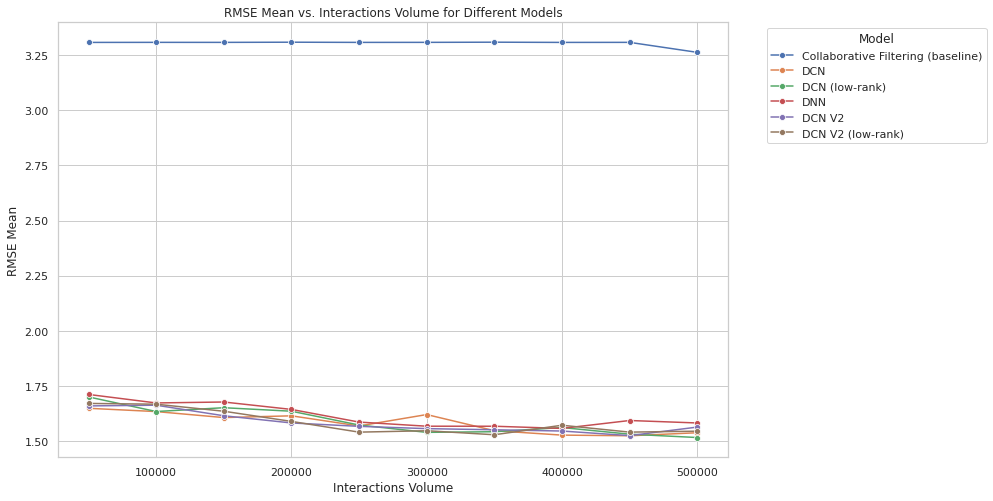

In [27]:
# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=all_results_df, x='Interactions', y='RMSE Mean', hue='Model', marker='o')

# Add title and labels
plt.title('RMSE Mean vs. Interactions Volume for Different Models')
plt.xlabel('Interactions Volume')
plt.ylabel('RMSE Mean')

# Show legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

The plot shows the base model i.e. collaborative filtering model as the worst performing model, followed by vanilla feed forward dense neural network (DNN).

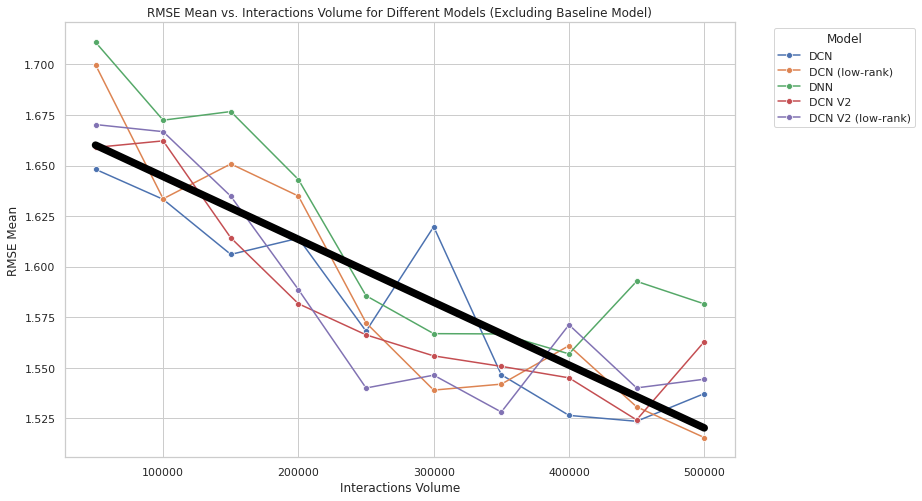

In [37]:
# Filter the data to exclude baseline model
filtered_results_df = all_results_df[all_results_df['Model'] != 'Collaborative Filtering (baseline)']

# Create the plot
plt.figure(figsize=(12, 8))
sns.lineplot(data=filtered_results_df, x='Interactions', y='RMSE Mean', hue='Model', marker='o')

# Add regression trend fit curve
sns.regplot(data=filtered_results_df, x='Interactions', y='RMSE Mean', scatter=False, ci=None, line_kws={'linewidth':7.5, 'color': 'black'})

# Add title and labels
plt.title('RMSE Mean vs. Interactions Volume for Different Models (Excluding Baseline Model)')
plt.xlabel('Interactions Volume')
plt.ylabel('RMSE Mean')

# Show legend
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

This plot shows that excluding the baseline model, rest of the models somewhat follow the performance trend with DNNs overpowered by variants of DCN in all the cases.

## RMSE vs. Interactions Volume for each Model

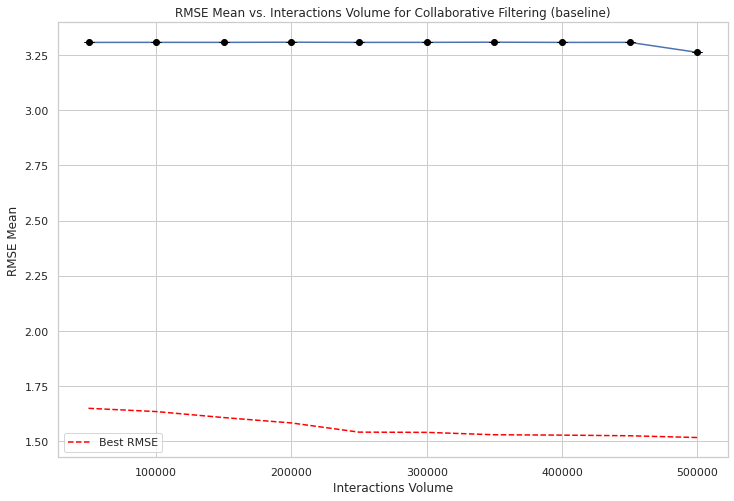

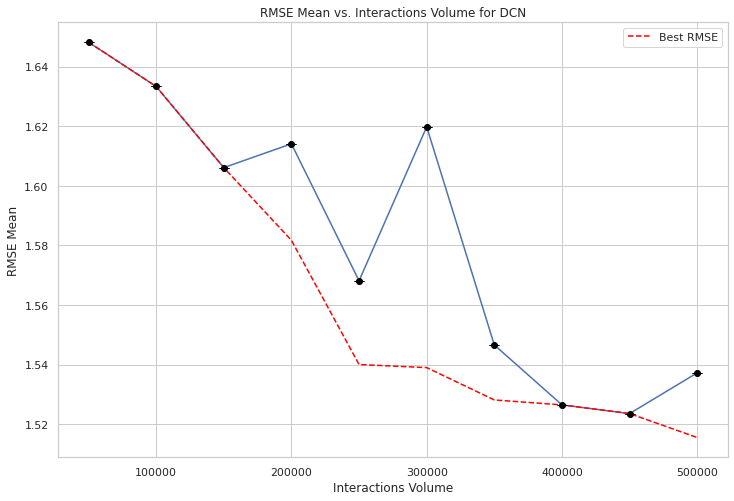

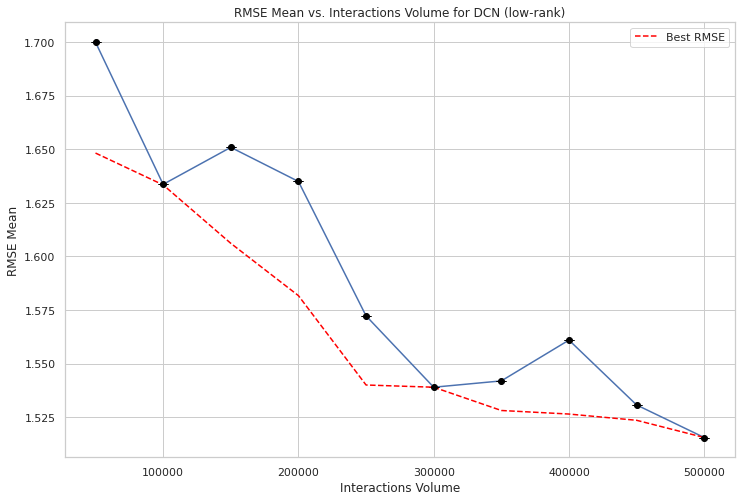

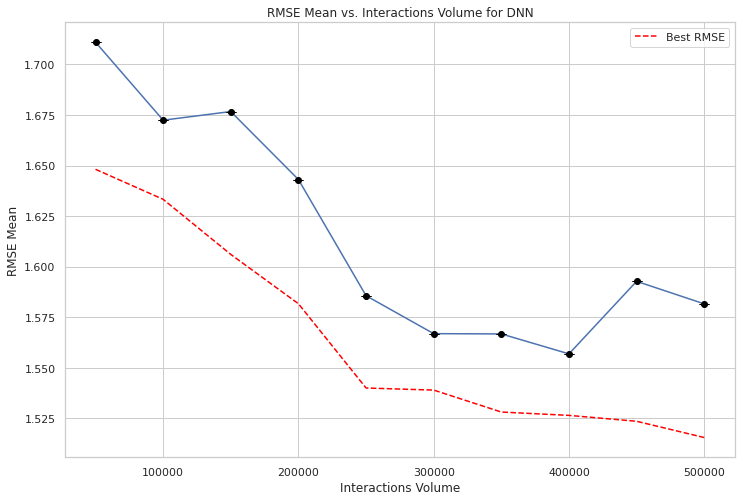

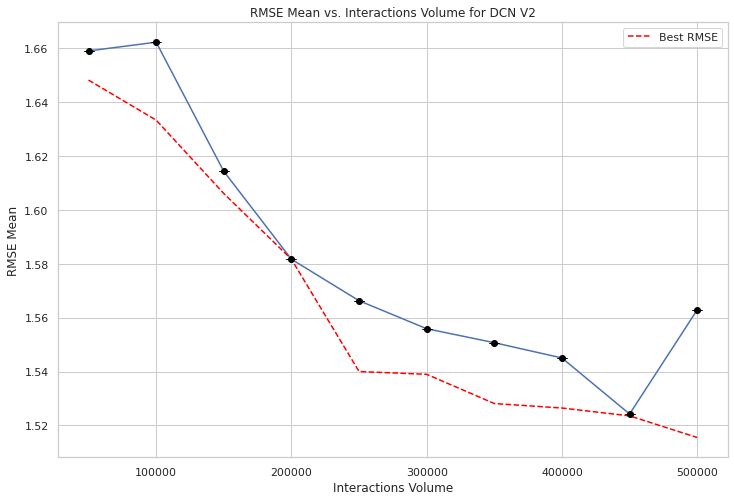

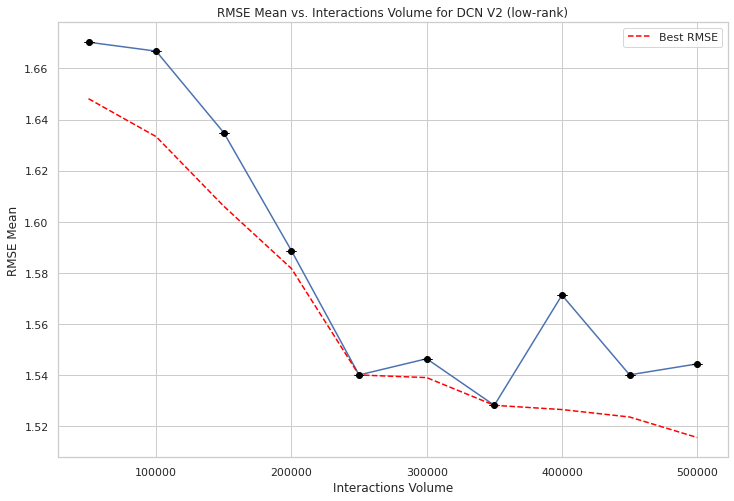

In [40]:
# Group by 'Interactions' and find the row with the minimum 'RMSE Mean' for each group
best_per_interaction = all_results_df.loc[all_results_df.groupby('Interactions')['RMSE Mean'].idxmin()]

# Get unique model names
unique_models = all_results_df['Model'].unique()

# Loop through each unique model
for model_name in unique_models:
    # Filter data for the current model
    model_data = all_results_df[all_results_df['Model'] == model_name]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=model_data, x='Interactions', y='RMSE Mean', marker='o', errorbar='sd')  # Use 'sd' for standard deviation
    
    # Add error bars
    plt.errorbar(model_data['Interactions'], model_data['RMSE Mean'], yerr=model_data['Stdv'], fmt='o', color='black', capsize=5)
    
    # Plot the best RMSE for each interaction as a reference line
    plt.plot(best_per_interaction['Interactions'], best_per_interaction['RMSE Mean'], linestyle='--', color='red', label='Best RMSE')
    
    # Add title and labels
    plt.title(f'RMSE Mean vs. Interactions Volume for {model_name}')
    plt.xlabel('Interactions Volume')
    plt.ylabel('RMSE Mean')
    
    # Show legend
    plt.legend()
    
    # Show plot
    plt.show()

These plots show that DCN variants have shown remarkable performance as compared to DNN. Specifically, low ranking version of DCN does a comparable performance in many of the set of interactions suggesting that approximation of weights is not always a bad choice in reducing costs of operation. Overall these plots highlight the fact that DCN can identify both implicit and explicit connections that may exist within the features and enhance model performance.

In [41]:
best_results_df

,Interactions Volume,Best Models,Best RMSE Means,Best Standard Deviations
0,50000,DCN,1.648163,0.0
1,100000,DCN,1.633316,0.0
2,150000,DCN,1.606077,0.0
3,200000,DCN V2,1.581685,0.0
4,250000,DCN V2 (low-rank),1.540007,0.0
5,300000,DCN (low-rank),1.538976,0.0
6,350000,DCN V2 (low-rank),1.528125,0.0
7,400000,DCN,1.526466,0.0
8,450000,DCN,1.523553,0.0
9,500000,DCN (low-rank),1.515514,0.0


## Plotting RMSE vs. Number of Interactions for Best Models

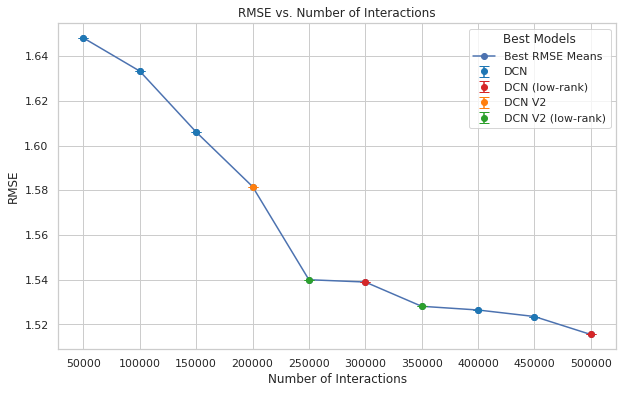

In [42]:
# Get unique models from the dataframe
unique_models = best_results_df['Best Models'].unique()

# Generate colors for each unique model
colors = plt.cm.tab10(range(len(unique_models)))

# Create a dictionary to map each model to a color
model_color_map = dict(zip(unique_models, colors))

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the main line graph
plt.plot(best_results_df['Interactions Volume'], best_results_df['Best RMSE Means'], marker='o', label='Best RMSE Means')

# Plot error bars for each model
for model, group in best_results_df.groupby('Best Models'):
    plt.errorbar(group['Interactions Volume'], group['Best RMSE Means'], yerr=group['Best Standard Deviations'], fmt='o', capsize=5, label=model, color=model_color_map[model])

# Add labels and title
plt.xlabel('Number of Interactions')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Interactions')

# Add legend
plt.legend(title='Best Models')

# Add grid
plt.grid(True)

# Set xticks to match the data points
plt.xticks(best_results_df['Interactions Volume'])

# Display the plot
plt.show()

As evident from the above plot, with the increasing number of interactions the DCN variants have consistently managed to improve the performance on unseen validation dataset.

## Produce recommendations (predict ranking scores) using best model

In [45]:
dcn_lr_result = run_models(cross_layer_num=1,
                           projection_dim=16,
                           deep_layer_sizes=[64, 64],
                           embedding_dimension=16) # Ideally it will be replaced by a saved model load step

best_model = dcn_lr_result['model'][0]

# Predict on test set
predictions = best_model.predict(test.batch(640).cache())

test_df = pd.DataFrame(test)
test_df['product_id'] = [tensor.numpy().decode('utf-8') for tensor in test_df['product_id'].values]
test_df['user_id'] = [tensor.numpy().decode('utf-8') for tensor in test_df['user_id'].values]
test_df['timestamp_buckets'] = [tensor.numpy() for tensor in test_df['timestamp_buckets'].values]
test_df['customer_city'] = [tensor.numpy().decode('utf-8') for tensor in test_df['customer_city'].values]
test_df['product_category'] = [tensor.numpy().decode('utf-8') for tensor in test_df['product_category'].values]
test_df['score'] = [tensor.numpy() for tensor in test_df['score'].values]

predictions_df = pd.DataFrame(predictions, columns=['predicted_score'])

# Concatenate test features and predictions
final_df = pd.concat([test_df, predictions_df], axis=1)

# Display the result DataFrame
final_df.head()

391/391 [==============================] - 22s 14ms/step


,product_id,user_id,timestamp_buckets,customer_city,product_category,score,predicted_score
0,electronics SKU 482,bc40a240a191386933abeb4d7bb0ae36,446,niteroi,electronics,1.0,2.628619
1,health_beauty SKU 136,bde74caf8848f8c4bf541c0098f0c9eb,445,porto alegre,health_beauty,1.0,3.747503
2,pet_shop SKU 128,bdb0cacd07b6749c702221f3a93417f7,669,cajamar,pet_shop,1.0,3.954851
3,watches_gifts SKU 1143,c14f30ca1ead07bd78cb1c97765cd97e,494,joao neiva,watches_gifts,2.0,2.872375
4,sports_leisure SKU 186,c0ca0f488078e67aa95aa1f873f0242f,198,rolandia,sports_leisure,5.0,3.391740


## Process the entire (HUGE - 10M!) synthetic interactions and showcase performance using a low ranking DCN variant

In [46]:
# Reading transaction data
df = pd.read_csv(
    '../data/all_transaction_data.csv'
)

# Transforming 'quantity' and 'price' columns into 'cost' by scaling between 0 and 1
df['cost'] = (df['quantity'] * df['price']).transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Aggregating interactions by grouping user, product, timestamp, city, and category, and computing sum of 'cost' and mean of 'review_score'
interactions_df = df.groupby(['user_id', 'product_id', 'timestamp', 'customer_city', 'product_category']).agg({'cost': 'sum', 'review_score': 'mean'}).reset_index().rename(columns={'review_score': 'rating'})

# Scaling 'rating' between 0 and 1
interactions_df['rating'] = (interactions_df['rating'] - interactions_df['rating'].min()) / (interactions_df['rating'].max() - interactions_df['rating'].min())

# Creating timestamp buckets of 24 hours
timestamp_buckets = np.arange(interactions_df['timestamp'].min(), interactions_df['timestamp'].max() + 24 * 60 * 60, 24 * 60 * 60)
interactions_df['timestamp_buckets'] = pd.cut(interactions_df['timestamp'], bins=timestamp_buckets, labels=False)

# Handling zero values in 'cost' and 'rating' by replacing them with 0.1
interactions_df['cost'] = interactions_df['cost'].replace(0, 0.1)
interactions_df['rating'] = interactions_df['rating'].replace(0, 0.1)

# Computing 'score' by multiplying 'cost' and 'rating'
interactions_df['score'] = interactions_df['cost'] * interactions_df['rating']

# Creating score percentiles and mapping scores to corresponding labels
percentiles = [0, 20, 40, 60, 80, 100]
thresholds = [interactions_df['score'].quantile(p / 100) for p in percentiles]
labels = [str(i) for i in range(1, len(percentiles))]
interactions_df['score'] = pd.cut(interactions_df['score'], bins=thresholds, labels=labels, include_lowest=True).astype(int)

# Converting DataFrame to dictionary for TensorFlow Dataset creation
interactions_dict = {name: np.array(value) for name, value in interactions_df.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

# Mapping features to appropriate data types and printing sample interaction
interactions = interactions.map(lambda x: {
    "product_id": x["product_id"],
    "user_id": x["user_id"],
    "timestamp_buckets": int(x["timestamp_buckets"]),
    "customer_city": x["customer_city"],
    "product_category": x["product_category"],
    "score": float(x["score"])
})
print("\nInteraction sample:")
for x in interactions.take(1).as_numpy_iterator():
    pprint.pprint(x)

# Total number of interactions
print(f"\nTotal interactions: {len(interactions)}")

n_interactions = len(interactions)
shuffled = interactions.shuffle(10_000, seed=42, reshuffle_each_iteration=False).take(n_interactions)

# Splitting into train, validation, and test sets
train_size = int(0.5 * n_interactions)
eval_size = int(0.25 * n_interactions)
all_train = shuffled.take(train_size)
val = shuffled.skip(train_size).take(eval_size)
test = shuffled.skip(train_size + eval_size)

print(f"\nTrain Size: {len(all_train)}, Validation Size: {len(val)}, Test Size: {len(test)}")

# Initialize variables to store best performance
best_val_rmse = float('inf')
best_model = None
val_rmse_history = []

# Start time for tracking total training time
train_start_time = time.time()

for i in range(10):
    loop_start_time = time.time()
    
    i_train_size = int(len(all_train)/10)*(i+1)
    train = all_train.take(i_train_size)
    
    print(f"\nRunning with {len(train)} training samples")
    
    epochs = 10
    learning_rate = 0.001

    # Define and compile the model
    model = DCN(cross_layer_num=2,
                deep_layer_sizes=[64, 64],
                projection_dim=16,
                embedding_dimension=16)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    
    model.fit(train.batch(128).cache(), epochs=epochs, verbose=False)
    metrics = model.evaluate(val.batch(64).cache(), return_dict=True)
    
    val_rmse = metrics['RMSE']
    val_rmse_history.append(val_rmse)
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model

    print(f"Iteration {i+1} - Validation RMSE: {val_rmse:.4f}, Best RMSE: {best_val_rmse:.4f}, Time: {time.time() - loop_start_time:.2f}s")

print(f"\nOverall Best Validation RMSE: {best_val_rmse:.4f}")

# Total training time
print(f"Total Training Time: {time.time() - train_start_time:.2f}s")


Interaction sample:
{'customer_city': b'cajamar',
 'product_category': b'UNKNOWN',
 'product_id': b'UNKNOWN SKU 4',
 'score': 2.0,
 'timestamp_buckets': 164,
 'user_id': b'0000366f3b9a7992bf8c76cfdf3221e2'}

Total interactions: 9999961

Train Size: 4999980, Validation Size: 2499990, Test Size: 2499991

Running with 499998 training samples
39063/39063 [==============================] - 251s 3ms/step - RMSE: 1.5996 - loss: 2.5588 - regularization_loss: 0.0000e+00 - total_loss: 2.5588
Iteration 1 - Validation RMSE: 1.5996, Best RMSE: 1.5996, Time: 412.67s

Running with 999996 training samples
39063/39063 [==============================] - 189s 2ms/step - RMSE: 1.5580 - loss: 2.4273 - regularization_loss: 0.0000e+00 - total_loss: 2.4273
Iteration 2 - Validation RMSE: 1.5580, Best RMSE: 1.5580, Time: 474.37s

Running with 1499994 training samples
39063/39063 [==============================] - 185s 2ms/step - RMSE: 1.5151 - loss: 2.2955 - regularization_loss: 0.0000e+00 - total_loss: 2.2955

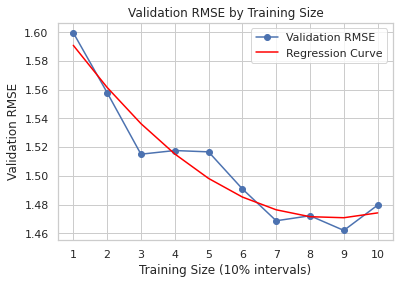

In [48]:
# Fit a polynomial regression curve
degree = 2
coefficients = np.polyfit(range(1, 11), val_rmse_history, degree)
poly = np.poly1d(coefficients)

# Plotting validation RMSE by training size with polynomial regression curve
plt.plot(range(1, 11), val_rmse_history, marker='o', label='Validation RMSE', linestyle='-')
plt.plot(range(1, 11), poly(range(1, 11)), color='red', label='Regression Curve')
plt.xlabel('Training Size (10% intervals)')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE by Training Size')
plt.xticks(range(1, 11))
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Predict on test set
predictions = best_model.predict(test.batch(640).cache())

test_df = pd.DataFrame(test)
test_df['product_id'] = [tensor.numpy().decode('utf-8') for tensor in test_df['product_id'].values]
test_df['user_id'] = [tensor.numpy().decode('utf-8') for tensor in test_df['user_id'].values]
test_df['timestamp_buckets'] = [tensor.numpy() for tensor in test_df['timestamp_buckets'].values]
test_df['customer_city'] = [tensor.numpy().decode('utf-8') for tensor in test_df['customer_city'].values]
test_df['product_category'] = [tensor.numpy().decode('utf-8') for tensor in test_df['product_category'].values]
test_df['score'] = [tensor.numpy() for tensor in test_df['score'].values]

predictions_df = pd.DataFrame(predictions, columns=['predicted_score'])

# Concatenate test features and predictions
final_df = pd.concat([test_df, predictions_df], axis=1)

# Display the result DataFrame
# final_df.head()

3907/3907 [==============================] - 226s 16ms/step


## Conclusion, learnings and future work:

1. With a sparse dataset, it's crucial to be cautious when interpreting the loss curve (training vs. validation). Misinterpretation can occur, affecting performance evaluation. Further investigation into alternative evaluation metrics or techniques may be beneficial.

2. Given the current environment setup, there's a risk of encountering Out Of Memory (OOM) issues, particularly as model complexity increases. Future decisions regarding model complexity should be made with resource constraints in mind to ensure scalability and efficiency.

3. While the focus of the project was on building a prototype using ranking scores for digital asset management, exploring other recommender models could provide valuable insights and potentially enhance recommendation quality.